# Main Figures
**Code for reproducing main figures in the manuscript**

For any question please contact the first author Yang Luo: yangluo@broadinstitute.org

## load up settings

In [110]:
#Load libraries
library(ggplot2)
library(reticulate)
library(repr)
library(patchwork)
library(tidyr)
library(plyr) 
library(dplyr)
library(data.table)
library(scales)
library(ggthemes)
library(ggsci)
library(plotrix)
library(RColorBrewer)
library(ggrepel)
library(gridExtra)
library(cowplot)
library(grid)
library(corrplot)
library(stringr)

In [70]:
# set global plotting parameters
theme_set(theme_bw() + theme(text = element_text(size=20, family = "sans")))

options(repr.plot.width = 10, repr.plot.height = 7)

pop_colors <- c("#938dd2","#E69F00" ,"#56B4E9","#D55E00","#009E73")
pop_labels <- c("Admixed African","East Asian","European","Latino", "South Asian")

#Calc color palette (discrete)
gene_colors <- c("A"="#004586", "B" = "#ff420e", "C"="#ffd320", 
                 "DQA1" = "#579d1c", "DQB1" = "#7e0021", "DRB1" = "#83caff","DPA1" = "#314004", "DPB1" = "#aecf00"  )

panel_colors <- c("darkorchid4", "plum","darkorange")
panel_names <- c("Multi-ethnic WGS (21,546)","Down-sampled WGS (5,225)",
                                      "T1DGC (5,225)")

## Population Diversity (Figure 1)

### PCA analysis (Figure 1a)

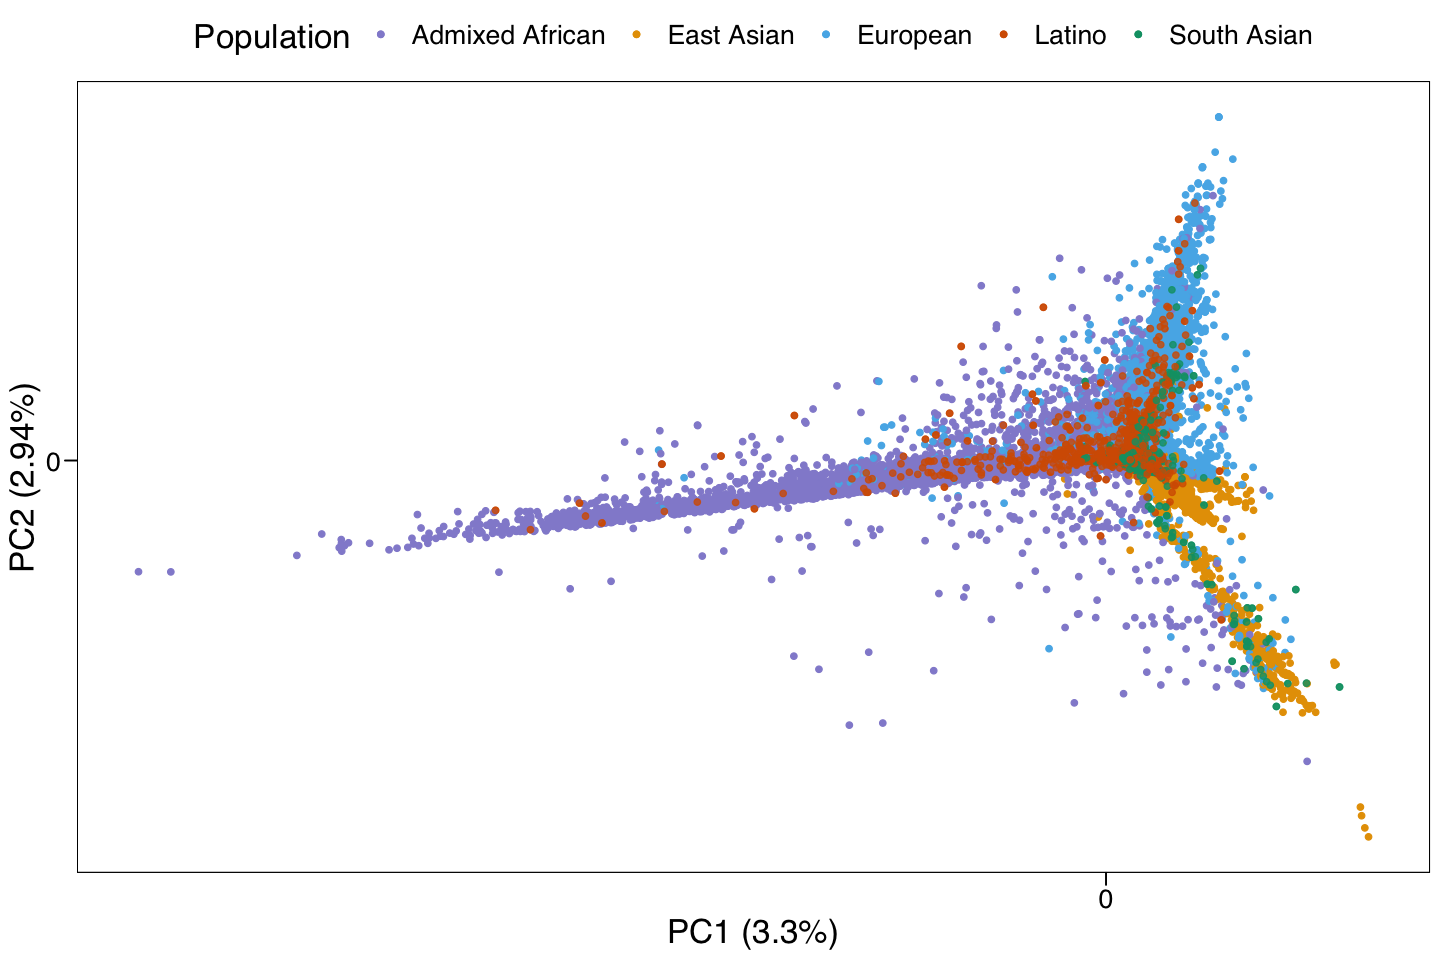

In [3]:
options(repr.plot.width = 12, repr.plot.height = 8)

pc <- read.table("../data//all_ibd_pcs.txt.gz",h=T,stringsAsFactors = F)

# for better visualization
pc$label <- "a"
pc[pc$ancestry=="LAT" | pc$ancestry=="SAS",]$label <- "focus" 

varexp <- c(0.033,0.0294)*100


weightedpc.plot <- ggplot(pc,aes(x=V1,y=V2,colour=ancestry, alpha = label )) + geom_point() +
    geom_point(data=subset(pc,label == "focus"), aes(x=V1,y = V2, color = ancestry)) +
    scale_alpha_manual(guide="none",values=list(a=1,focus=.8))


weightedpc.plot <- weightedpc.plot + scale_colour_manual(values=pop_colors,
                                                         name="Population",
                                                        labels=pop_labels)
weightedpc.plot <- weightedpc.plot + theme_base() 

weightedpc.plot <- weightedpc.plot + 
  xlab(paste("PC1 (",round(varexp[1],2),"%)",sep=""))+ylab(paste("PC2 (",round(varexp[2],2),"%)",sep=""))


weightedpc.plot  <- weightedpc.plot + theme(legend.position="top",
                        plot.background=element_blank(),
                        text = element_text(size = 20, family = "sans"))
weightedpc.plot  <- weightedpc.plot  + scale_x_continuous(breaks = 0) + scale_y_continuous(breaks = 0)

weightedpc.plot
ggsave(filename = "../figs/Fig1a-PCA.png",height=8,width=10)


### B frequencies by continental groups (Figure 1b)

In [5]:
#' Plots a series of barplots and connects them 
#' Modified from https://stackoverflow.com/questions/22560850/barplot-with-connected-series
#' 
#' @param dat NxM matrix with N rows as features and M columns as samples
#' @param color Vector of N colors
#' @param space Space between barplots
#' @param alpha Alpha for area connecting barplots
#' 
#' @examples
#' dat <- matrix(rnorm(100),10,10)
#' dat <- abs(matrix(rnorm(100),10,10)) 
#' connectedBarplot(dat, color=rainbow(nrow(dat)))
#'

connectedBarplot <- function(dat, color=rainbow(nrow(dat)), space=.21, alpha=0.5, dist=.5, ...) {  
  b <- barplot(dat, col=color, space = space, ...)                     
  H <- apply(dat, 2L, cumsum)
  H <- H - dat / 2
  text(rep(b, each = nrow(H)), H, labels = rownames(dat))
  
  for (i in seq_len(ncol(dat) - 1)) {     
    lines(c(b[i]+dist, b[i+1]-dist), c(0, 0)) ## bottom line       
    
    for (j in seq_len(nrow(dat))) {     
      if (j == 1) {                   
        lines(c(b[i]+dist, b[i+1]-dist), c(dat[j,i], dat[j,i+1]))                       
        polygon(c(b[i]+dist, b[i]+dist, b[i+1]-dist, b[i+1]-dist),                        
                c(0, dat[j,i], dat[j,i+1], 0),               
                col=adjustcolor(color[j], alpha.f=alpha))    
      }      
      if (j == 2) {                   
        lines(c(b[i]+dist, b[i+1]-dist), c(colSums(dat[1:j,])[i], colSums(dat[1:j,])[i+1]))                      
        polygon(c(b[i]+dist, b[i]+dist, b[i+1]-dist, b[i+1]-dist),                        
                c(dat[1,i], colSums(dat[1:j,])[i], colSums(dat[1:j,])[i+1], dat[1,i+1]),                       
                col=adjustcolor(color[j], alpha.f=alpha))    
      }      
      if (j > 2) {                    
        lines(c(b[i]+dist, b[i+1]-dist), c(colSums(dat[1:j,])[i], colSums(dat[1:j,])[i+1]))                      
        polygon(c(b[i]+dist, b[i]+dist, b[i+1]-dist, b[i+1]-dist),                        
                c(colSums(dat[1:(j-1),])[i], colSums(dat[1:j,])[i], colSums(dat[1:j,])[i+1], colSums(dat[1:(j-1),])[i+1]),              
                col=adjustcolor(color[j], alpha.f=alpha))    
      #    legend("top", inset=c(0,0), rev(rownames(dat)), fill = rev(color), ncol = 1, cex = 2)
      }      
    }          
  } 
    
}   

In [4]:
Ggroup<-read.table("../data/Ggroups.txt.gz",h=T,sep=" ")
Ggroup[Ggroup$ethnicity == "missing", ]$ethnicity <- "AFR"
Ggroup$ethnicity <- factor(Ggroup$ethnicity)
#creat frequency table

create_table<-function(dat=Ggroup,genes=c("A","B","C","DQA1","DQB1","DRB1","DPA1","DPB1")){
    out<-NULL
    for (gene in genes){
        x<-subset(dat,select=c(paste(gene,"1",sep="")))%>% unlist() %>% as.vector()
        y<-subset(dat,select=c(paste(gene,"2",sep="")))%>% unlist() %>% as.vector()
        df<-c(x,y)
        frq<-as.data.frame(table(df)/(nrow(dat)*2))
        frq$Gene <- gene
        out<-rbind(out,frq)
    }
    names(out)[1]<-"Var1"
    return(out)
}


In [6]:
all <- ddply(Ggroup[,1:16], .(Ggroup$ethnicity), create_table)

names(all)[1]<-"superpop"

#define top most frequent alleles
df2<-all %>% group_by(Gene,superpop) %>% top_n(2, Freq) %>% arrange(Gene,superpop,desc(Freq))
others<-setDT(all[all$Var1 %in% df2$Var1,])[, .(Var1="others",Freq=1-sum(Freq)), by= .(Gene, superpop)] 


df3<-rbind(all[all$Var1 %in% df2$Var1,],others)
count<-aggregate(df3$Var1, list(df3$Gene),unique)


In [10]:
ancs <- c('AA','EUR','LAT','EAS','SAS')
df3[df3$superpop=="AFR",]$superpop <- "AA"
alleles <- unique(df3[df3$Gene=="B",2])

plt <- matrix(0L,ncol=length(ancs),nrow=nrow(alleles))
n <- 1
for (anc in ancs){
    y <- df3[df3$Gene=="B" & df3$superpop==anc,]
    plt[,n] <- y[match(alleles$Var1, y$Var1),]$Freq*100
    n <- n + 1
}

plt[is.na(plt)] <- 0

plt <- cbind(plt,rowMeans(plt))
colnames(plt) <- c(ancs,"ALL")
rownames(plt) <- alleles$Var1

df.plt <- plt[order(plt[,6],decreasing = T),-6]
head(df.plt)
options(repr.plot.width = 15, repr.plot.height = 8)
pdf("../figs/Fig1b-Bfreq.pdf",width=11,height=7)
op <- par(family = "sans")

layout(rbind(1,2), height=c(2,7))  # put legend on bottom 1/8th of the chart
# setup for no margins on the legend
par(mar=c(3, 5, 0, 0))
# c(bottom, left, top, right)
plot.new()
legend("center", rev(rownames(df.plt)),bty ="n",ncol=5,x.intersp=0.25,text.width=.17,
       fill = rev(c("grey",brewer.pal(nrow(plt)-1,"Paired"))), cex = 1.5)

# setup for no margins on the legend
#par(mar=c(0, 0, 0, 0))
# c(bottom, left, top, right)
#plot.new()
connectedBarplot(df.plt , space=0.3,color=c("grey",brewer.pal(nrow(plt)-1,"Paired")),alpha=.2,ylab="Allele frequency",
                 cex.names=2,cex.lab=1.8,cex.axis=1.5)


dev.off()


,AA,EUR,LAT,EAS,SAS
others,69.0024207,60.5624816,80.3571429,62.3006283,57.361963
B*07:02:01G,6.9754109,13.1638363,6.1974790,3.5524408,3.987730
B*35:01:01G,6.4403109,5.5610091,5.6197479,5.3165781,3.987730
B*08:01:01G,3.7138489,10.8667910,3.0462185,0.1933301,4.907975
B*40:01:01G,1.3058988,5.2616079,1.6281513,8.8690188,1.635992
B*52:01:01G,0.1974774,0.8098557,0.7878151,6.5490575,9.304703


pdf 
  2

### DQA1 frequencies by continetal groups (Figure 1c)

In [12]:
alleles <- unique(df3[df3$Gene=="DQA1",2])
df3[df3$Var1 == "DQA1*02:01",]$Var1 <- "DQA1*02:01:01G"

plt <- matrix(0L,ncol=length(ancs),nrow=nrow(alleles))
n <- 1
for (anc in ancs){
    y <- df3[df3$Gene=="DQA1" & df3$superpop==anc,]
    plt[,n] <- y[match(alleles$Var1, y$Var1),]$Freq*100
    n <- n + 1
}

plt[is.na(plt)] <- 0

plt <- cbind(plt,rowMeans(plt))
colnames(plt) <- c(ancs,"ALL")
rownames(plt) <- alleles$Var1

df.plt <- plt[order(plt[,6],decreasing = T),-6]
df.plt
options(repr.plot.width = 15, repr.plot.height = 8)
pdf("../figs/Fig1c-DQA1freq.pdf",width=11,height=7)
op <- par(family = "sans")

layout(rbind(1,2), height=c(2,7))  # put legend on bottom 1/8th of the chart
# setup for no margins on the legend
par(mar=c(3, 5, 0, 0))
# c(bottom, left, top, right)
plot.new()
legend("center", rev(rownames(df.plt)),bty ="n",ncol=5,x.intersp=0.25,text.width=.17,
       fill = rev(c("grey",brewer.pal(nrow(plt)-1,"Paired"))), cex = 1.5)

# setup for no margins on the legend
#par(mar=c(0, 0, 0, 0))
# c(bottom, left, top, right)
#plot.new()
connectedBarplot(df.plt , space=0.3,color=c("grey",brewer.pal(nrow(plt)-1,"Paired")),alpha=.2,ylab="Allele frequency",
                 cex.names=2,cex.lab=1.8,cex.axis=1.5)


dev.off()
#connectedBarplot(plt, space=0.3, color=c("grey",rep(pop_colors,2)),alpha=.2,ylab="Allele frequency")
                 #cex.names=1.5,cex.lab=1.5,cex.axis=1.5)


,AA,EUR,LAT,EAS,SAS
others,27.799720,17.870816,24.107143,21.29048,23.00613
DQA1*03:01:01G,11.033253,16.879356,25.315126,34.70275,10.02045
DQA1*05:01:01G,20.321060,26.234416,24.632353,11.64814,13.08793
DQA1*01:02:01G,29.417760,19.495435,11.239496,15.53891,11.55419
DQA1*01:03:01G,4.580201,7.146363,4.411765,13.84727,22.59714
DQA1*02:01:01G,6.848006,12.373613,10.294118,2.97245,19.73415


pdf 
  2

## HLA Haplotype (Figure 2)

### epsilon (Figure 2a)

In [163]:
M <- 0
for (pop in c("EUR","SAS","EAS","LAT","AA")){
  M1 <- as.matrix(read.table(paste("../data/",pop,"_eps.txt",sep=""),h=T,stringsAsFactors = F))
  M <- M + M1
}

#M/5
rownames(M)<-colnames(M)<-c("A","C","B","DRB1","DQA1","DQB1","DPA1","DPB1")


cols <- colorRampPalette(rev(pal_locuszoom(palette = c("default"))(4)))

pdf("../figs/Fig2a_all_eps.pdf",height=6,width=6)
  
#diag(M) = 1
corrplot.mixed(M/5, lower.col=cols(50),upper = "circle", 
                 tl.col = "black", upper.col = cols(50), cl.lim=c(0,.35),tl.cex=1.3)

dev.off()

pdf 
  2

### Figure 2b is generated using disentangler

http://kumasakanatsuhiko.jp/projects/disentangler/

with data `../data/subset_disentangler.txt` 

(a subset of individuals that are evenly distirubted among five populations)


## Imputation accuracy (Figure 3)


### Panel description (Figure 3a)

[1] 5.144295

[1] 2.755034

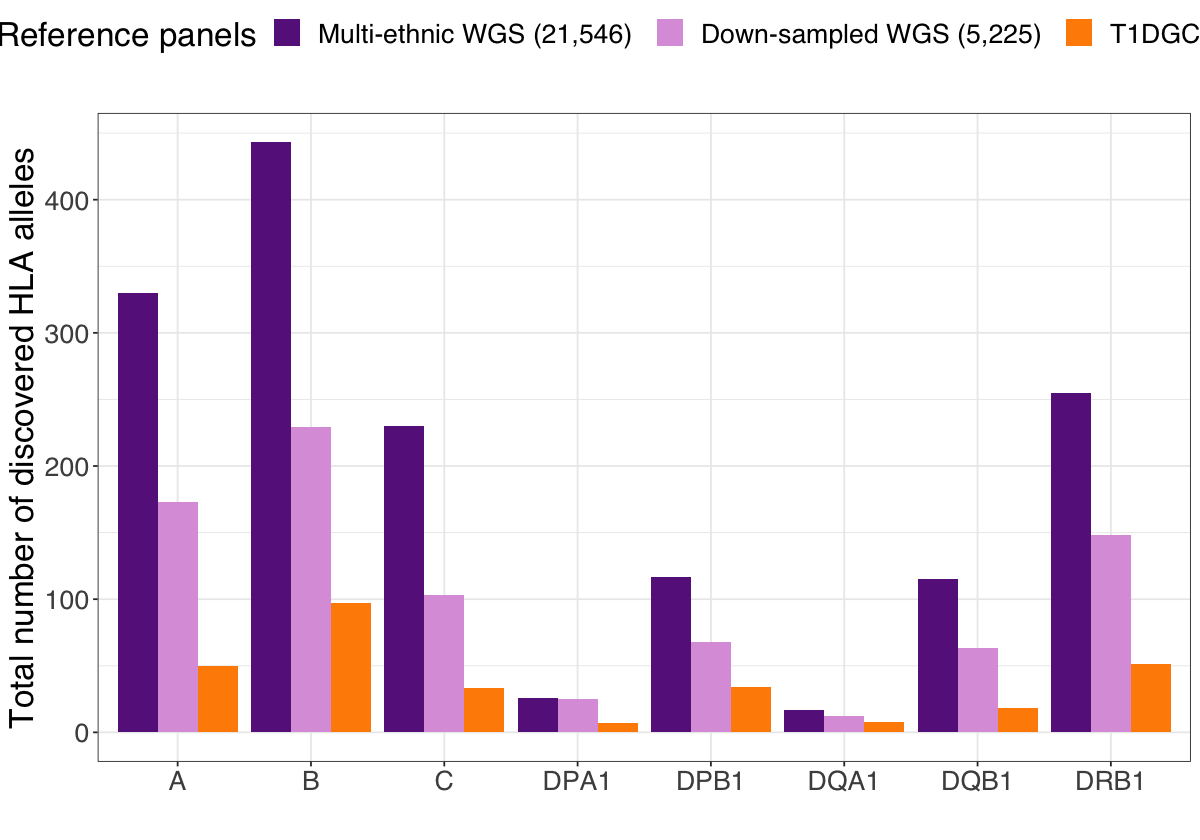

In [162]:
#count how many unique HLA genes have been observed in the wgs cohort of 21,546 individuals and a random subset of 5225 samples (same as T1DGC)

numHLA <- read.table("../data/REF_HLA_types.txt",h=T,stringsAsFactors = F)


# fold increase for number of included HLA alleles compared to T1DGC
sum(numHLA %>% filter(cohort=="WGS") %>% select(number))/
    sum(numHLA %>% filter(cohort=="T1DGC") %>% select(number))

sum(numHLA %>% filter(cohort=="WGS_subset") %>% select(number))/
    sum(numHLA %>% filter(cohort=="T1DGC") %>% select(number))

#plotting
genes<-c("A","B","C","DPA1","DPB1","DQA1","DQB1","DRB1")

numHLA$Genes<-rep(genes,3)

numHLA$cohort <- factor(numHLA$cohort,levels=c("WGS","WGS_subset","T1DGC"))

p_hla_number<-ggplot(numHLA,aes(x=Genes,y=number,fill=cohort))+
  geom_bar(stat="identity", position=position_dodge()) +
  scale_fill_manual(values=panel_colors,
                    name="Reference panels\n",
                             labels=panel_names)+
  ylab("Total number of discovered HLA alleles")+xlab("")+
theme(legend.position = "top")

p_hla_number

ggsave(p_hla_number,filename = "../figs/Fig3a_discovered_HLA_types.png",width=12,height=7)


### imputation r2 in 1000 Genomes (Figure 3b)

In [78]:
r2 <- read.table("../data/r2_summary.txt.gz",h=T,stringsAsFactors = F, comment.char = "#")

g1k <- r2 %>% select(allele,G1K_r2,G1K_freq) %>% na.omit()

In [154]:
# assign resolutions
g1k$num <- unlist(sapply(g1k$allele,function(x) str_count(x, ":")) )                   
g1k$resolution <- NA

g1k$resolution <- ifelse(g1k$num>=2,"G-group",g1k$resolution)
g1k$resolution <- ifelse(g1k$num==1,"two-field",g1k$resolution)
g1k$resolution <- ifelse(g1k$num==0,"one-field",g1k$resolution)


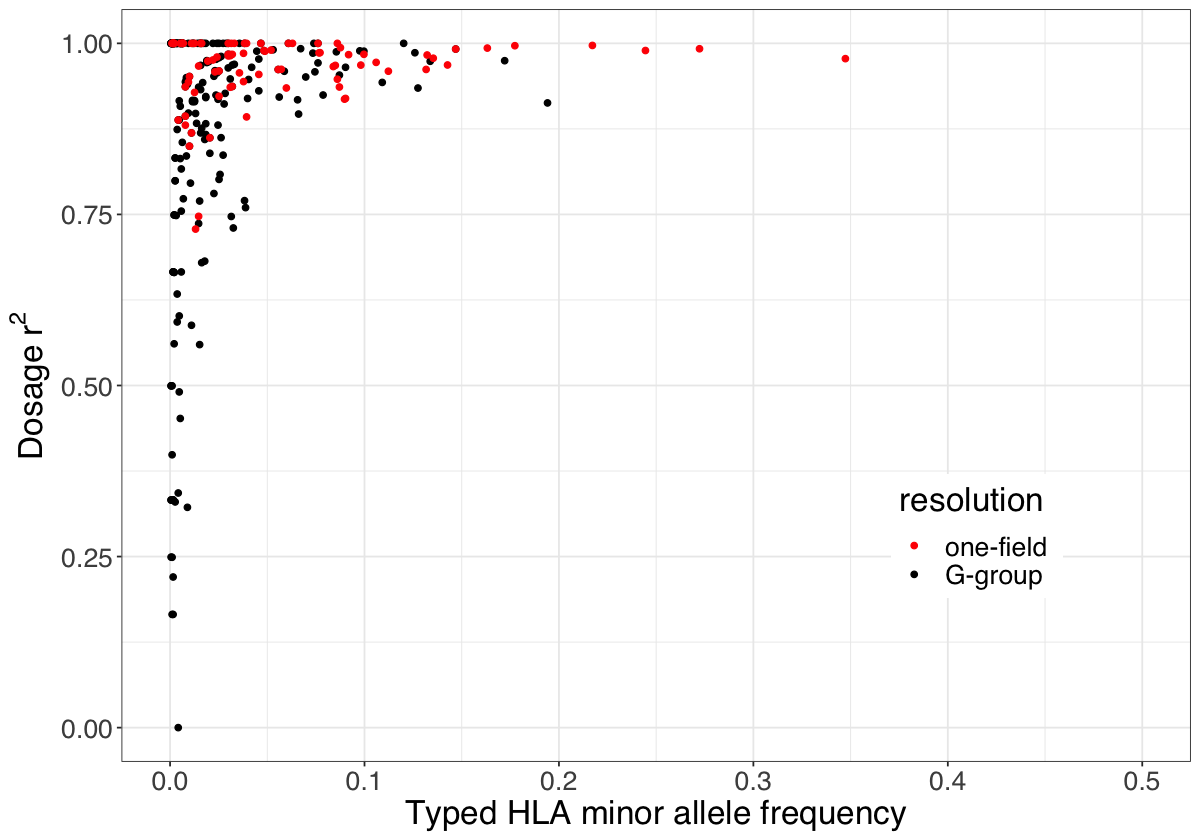

In [167]:
g1k$resolution <- factor(g1k$resolution, levels = c("one-field","two-field","G-group"))
ggplot(g1k %>% filter(resolution!="two-field"),aes(G1K_freq,G1K_r2,col=resolution)) + 
geom_point()  +
xlim(0,0.5) + ylim(0,1) + 
    xlab("Typed HLA minor allele frequency") + ylab(expression("Dosage"~r^2)) +
    scale_color_manual(values=c("red","black"),
                      labels = c("one-field","G-group")) +
    theme(legend.position=c(0.8,0.3))

ggsave(,filename = "../figs/Fig3b_dosage_r2.pdf",width=6,height=6)

# all three resolutions
# ggplot(g1k,aes(G1K_freq,G1K_r2,col=resolution)) + 
# geom_point() +
#     xlim(0,0.5) + ylim(0,1) + 
#     xlab("Typed HLA minor allele frequency") + ylab(expression("Dosage"~r^2)) +
#     scale_color_manual(values=c("red","blue","black"),
#                       labels = c("one-field","two-field","G-group")) +
#     theme(legend.position=c(0.9,0.3))

### Imputation accuracy by ethnicity (Figure 3d)

In [170]:
# load data from accuracy comparison
t1dgcAcc <- read.table("../data/g1k_t1dgc_Ggroup_accuracy.txt",h=T,stringsAsFactors = F)
wgsAcc <- read.table("../data/g1k_wgs_Ggroup_accuracy.txt",h=T,stringsAsFactors = F)
wgssubsetAcc <- read.table("../data/g1k_wgs_subset_ggroup_accuracy.txt",h=T,stringsAsFactors = F)


In [171]:
df1 <- t1dgcAcc %>% melt() %>% mutate(Ref = "T1DGC")
df2 <- wgsAcc %>% melt() %>% mutate(Ref = "WGS2") #everything
df3 <- wgssubsetAcc  %>% melt() %>% mutate(Ref = "WGS1")
df <- rbind(df1,df2,df3)

Warning message in melt(.):
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(.). In the next version, this warning will become an error.”
Using ethnicity as id variables

Warning message in melt(.):
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(.). In the next version, this warning will become an error.”
Using ethnicity as id variables

Warning message in melt(.):
“The melt ge

In [172]:
# with gapped y-axis (not the most beautiful code ..)
from <- 5; to <- 75
main.size <- 2.5
png("../figs/Fig3d_g1k_accuracy.png", height=1200,width = 1000)

par(mfrow=c(4,1), fg = "black")
par(mar=c(0,5,2,2))
anc <- "AFR"
y <- rbind(wgsAcc[wgsAcc$ethnicity == anc,],wgssubsetAcc[wgssubsetAcc$ethnicity == anc,],t1dgcAcc[t1dgcAcc$ethnicity == anc,])
rownames(y)<-c("wgs","wgssubset","t1dgc")

gap.barplot(rbind(c(0,0,0,0,100),as.matrix(y[,-1])*100), gap=c(from,to), col=rep(c("white",panel_colors),5),
           ylab = "", xlab ="",main = anc,xaxt='n', 
            cex.main = main.size, cex.axis = 2, ytics=c(0,5,80,90, 100))
axis.break(2, from, breakcol="snow", style="gap")
axis.break(2, from*(1+0.02), breakcol="black", style="slash")
axis.break(4, from*(1+0.02), breakcol="black", style="slash")
axis(2, at=c(0,from,to,100))

par(mar=c(0,5,2,2))
anc <- "EAS"
y <- rbind(wgsAcc[wgsAcc$ethnicity == anc,],wgssubsetAcc[wgssubsetAcc$ethnicity == anc,],t1dgcAcc[t1dgcAcc$ethnicity == anc,])
rownames(y)<-c("wgs","wgssubset","t1dgc")

gap.barplot(rbind(c(0,0,0,0,100),as.matrix(y[,-1])*100), gap=c(from,to), col=rep(c("white",panel_colors),5),
           ylab = "", xlab ="",main = anc,xaxt='n', 
            cex.main = main.size, cex.axis = 2, ytics=c(0,5,80,90, 100))
axis.break(2, from, breakcol="snow", style="gap")
axis.break(2, from*(1+0.02), breakcol="black", style="slash")
axis.break(4, from*(1+0.02), breakcol="black", style="slash")
axis(2, at=from)
mtext("Imputation accuracy",side=2,col="black",cex=3, line = 3, 
     at=par("usr")[1]+0.05*diff(par("usr")[1:2]))


par(mar=c(0,5,2,2))
anc <- "EUR"
y <- rbind(wgsAcc[wgsAcc$ethnicity == anc,],wgssubsetAcc[wgssubsetAcc$ethnicity == anc,],t1dgcAcc[t1dgcAcc$ethnicity == anc,])
rownames(y)<-c("wgs","wgssubset","t1dgc")

gap.barplot(rbind(0,as.matrix(y[,-1])*100), gap=c(from,to), col=rep(c("white",panel_colors),5),
           ylab = "", xlab ="",main = anc,xaxt='n', 
            cex.main = main.size, cex.axis = 2, ytics=c(0,5,80,90, 100))
axis.break(2, from, breakcol="snow", style="gap")
axis.break(2, from*(1+0.02), breakcol="black", style="slash")
axis.break(4, from*(1+0.02), breakcol="black", style="slash")
axis(2, at=from)

par(mar=c(3,5,2,2))
anc <- "LAT"
y <- rbind(wgsAcc[wgsAcc$ethnicity == anc,],wgssubsetAcc[wgssubsetAcc$ethnicity == anc,],t1dgcAcc[t1dgcAcc$ethnicity == anc,])
rownames(y)<-c("wgs","wgssubset","t1dgc")

gap.barplot(rbind(0,as.matrix(y[,-1])*100), gap=c(from,to), col=rep(c("white",panel_colors),5),
           ylab = "", xlab ="",main = anc, ytics=c(0,5,80,90, 100), 
            cex.main = main.size , xaxt = "n", cex.axis = 2)
axis.break(2, from, breakcol="snow", style="gap")
axis.break(2, from*(1+0.02), breakcol="black", style="slash")
axis.break(4, from*(1+0.02), breakcol="black", style="slash")
axis(2, at=from)
axis(1, at = c(3,7,11,15,19), labels = c("A","B","C","DQB1","DRB1"), cex.axis=3) 


dev.off()

pdf 
  2

## HIV-1 associaiton study (Figure 5)

### position 97 frequencies (Figure 5a)

In [173]:
B97 <- read.table("../data/b97_summary.txt", h=T, stringsAsFactors = F)

In [175]:
mafbar<- ggplot(B97, aes(x=reorder(Residue,BETA), y=MAF, fill=POP)) + 
    geom_bar(position=position_dodge(), stat="identity")  

mafbar <- mafbar + ylab("Residue frequency") + xlab("")#+ xlab("Amino acid residues at position 97 in HLA-B")

mafbar <- mafbar + scale_fill_manual(values=pop_colors[c(1,3,4)],
                          labels=pop_labels[c(1,3,4)],
                    name = "Population") + theme(legend.position="top")


### position 97 betas (Figure 5b)

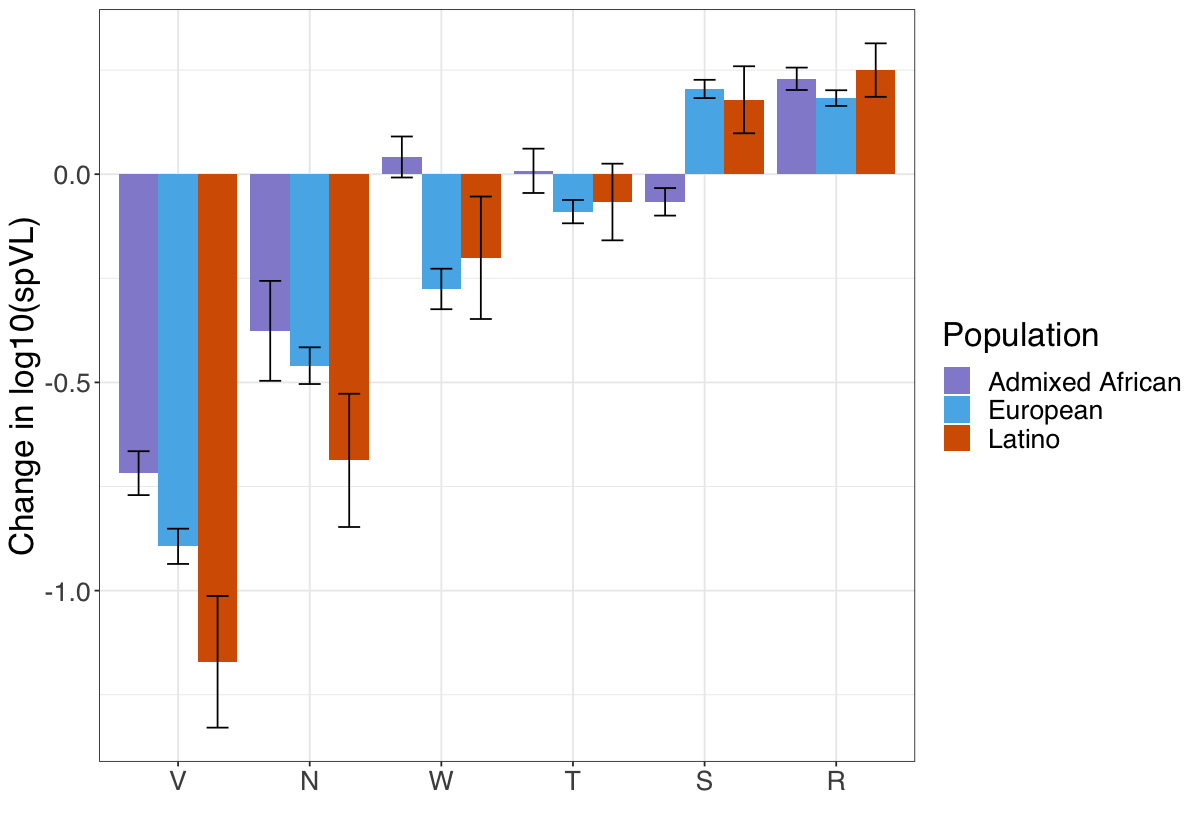

In [176]:
# Error bars represent standard error of the mean

betabar <- ggplot(B97, aes(x=reorder(Residue,BETA), y=BETA, fill=POP)) + 
    geom_bar(position=position_dodge(), stat="identity") +
    geom_errorbar(aes(ymin=BETA-SE, ymax=BETA+SE),
                  width=.5,                    # Width of the error bars
                  position=position_dodge(.9)) 
betabar <- betabar + ylab("Change in log10(spVL)")+ xlab("")# + xlab("Amino acid residues at position 97 in HLA-B")

betabar <- betabar + scale_fill_manual(values=pop_colors[c(1,3,4)],
                          labels=pop_labels[c(1,3,4)],
                    name = "Population")
betabar

In [178]:
# merge two plots
g_legend<-function(a.gplot){
  tmp <- ggplot_gtable(ggplot_build(a.gplot))
  leg <- which(sapply(tmp$grobs, function(x) x$name) == "guide-box")
  legend <- tmp$grobs[[leg]]
  return(legend)}

mylegend<-g_legend(mafbar)

prow <- plot_grid( mafbar + theme(legend.position="none"),
           betabar + theme(legend.position="none"),
           align = 'vh',
           labels = c("(a)", "(b)"),
           hjust = 0,
           nrow = 1
           )
png("../figs/Fig5ab_pos97.png", height = 7, width = 10, units= "in", res=200)
#create common x and y labels
x.grob <- textGrob("Amino acid residues at position 97 in HLA-B", 
                   gp=gpar(fontface="bold", col="black", fontsize=20), rot=0, vjust = .3)

#add to plot
p <- plot_grid( mylegend, prow,  ncol = 1, rel_heights = c( .2,1))

grid.arrange(arrangeGrob(p, bottom = x.grob))
dev.off()

pdf 
  2

### amino acid effect size across three populations (Figure 5d)

In [182]:
df <-read.table("../data/HIV_AA_summary.txt",h=T,stringsAsFactors = F)

df$label <- paste(df$aa_name,df$res,sep="")
df$reported <- paste(df$Current,df$McLaren_2012_AA,df$McLaren_2015_Euro,sep="")

df.plt = data.frame(AA = c(df$label,rep("", nrow(df)), rep("", nrow(df))),
                x = rep(df$joint_beta, 3),
                x.se = rep(df$joint_se, 3),
                y = c(df$aa_beta, df$eur_beta, df$lat_beta),
                y.se = c(df$aa_se, df$eur_se, df$lat_se),
                pop = rep(c("AA", "EUR" ,"LAT"), each = nrow(df)),
                reported = rep(df$reported,3))

Warning message:
“Removed 14 rows containing missing values (geom_errorbar).”
Warning message:
“Removed 12 rows containing missing values (geom_errorbarh).”
Warning message:
“Removed 12 rows containing missing values (geom_text_repel).”
Warning message:
“Removed 12 rows containing missing values (geom_point).”
Warning message:
“Removed 14 rows containing missing values (geom_errorbar).”
Warning message:
“Removed 12 rows containing missing values (geom_errorbarh).”
Warning message:
“Removed 12 rows containing missing values (geom_text_repel).”
Warning message:
“Removed 12 rows containing missing values (geom_point).”


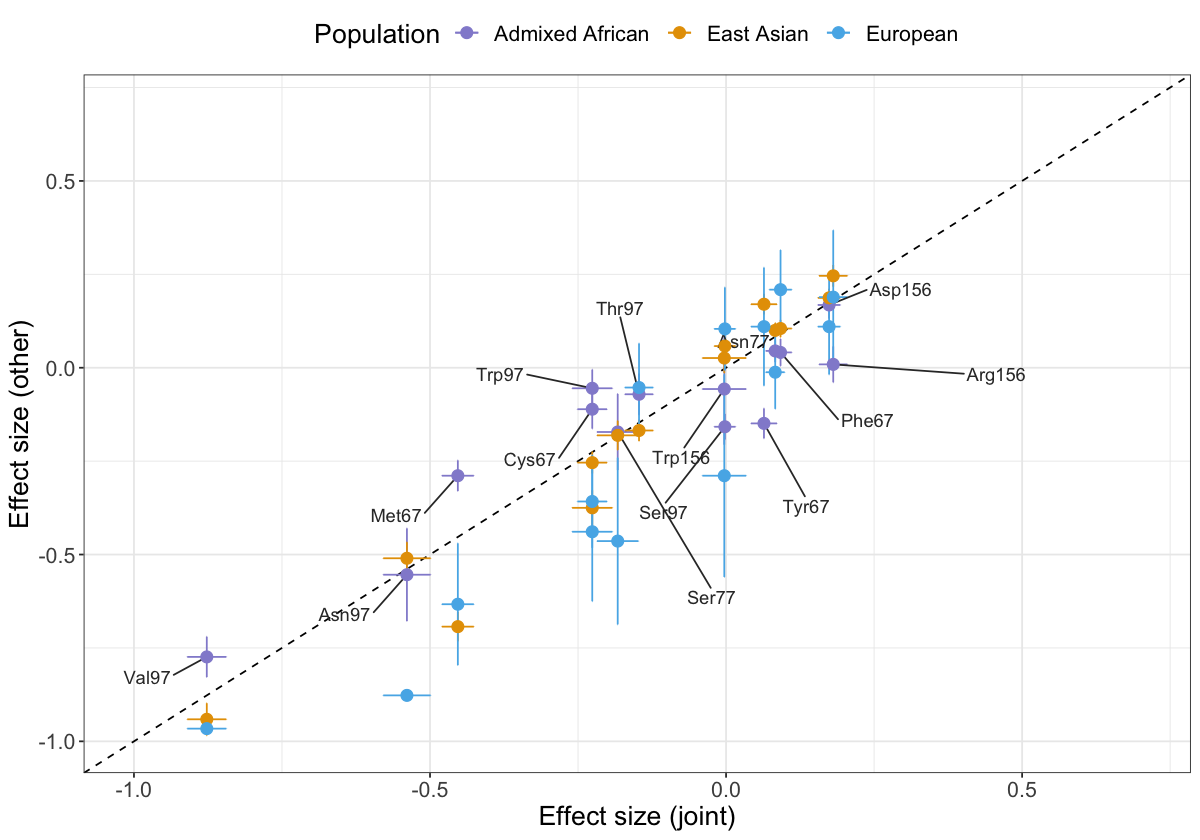

In [183]:

### four identified amino acids in this study only
plt =
  df.plt %>% filter(reported=="100" | reported=="110"| reported=="101" | reported == "111") %>%
  ggplot(aes(x, y, colour=pop)) +
  geom_abline(slope = 1, intercept = 0, linetype="dashed") +
  geom_errorbar(aes(ymin = y - y.se, ymax = y + y.se)) +
  geom_errorbarh(aes(xmin = x - x.se, xmax = x + x.se)) +
  geom_text_repel(aes(label = AA), show.legend = F, box.padding = 1.5, col = "grey20") +
  geom_point(size=3) +
  xlab('Effect size (joint)') +ylab('Effect size (other)')+
  theme_bw() +
  theme(text = element_text(size = 16))



plt + xlim(-1,0.7) + ylim(-1,0.7) +
  scale_color_manual(values=pop_colors,
                     labels=pop_labels,
                     name = "Population") +
  theme(legend.position = "top",legend.direction = "horizontal")

ggsave("../figs/Fig4d_HIV-4AAs-comparison.pdf",height=7,width=10)

### variance explained by haplotype (Figure 5e)

pos,EUR,AA,LAT,ALL
<int>,<dbl>,<dbl>,<dbl>,<dbl>
97,0.1086730,0.07701225,0.1473023,0.09060226
67,0.1315075,0.09675012,0.1655150,0.11220225
156,0.1344019,0.13841015,0.1749739,0.12920470
77,0.1485950,0.13728867,0.2626632,0.13664906


Warning message in melt(x[1:3, ], id = "pos"):
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(x[1:3, ]). In the next version, this warning will become an error.”


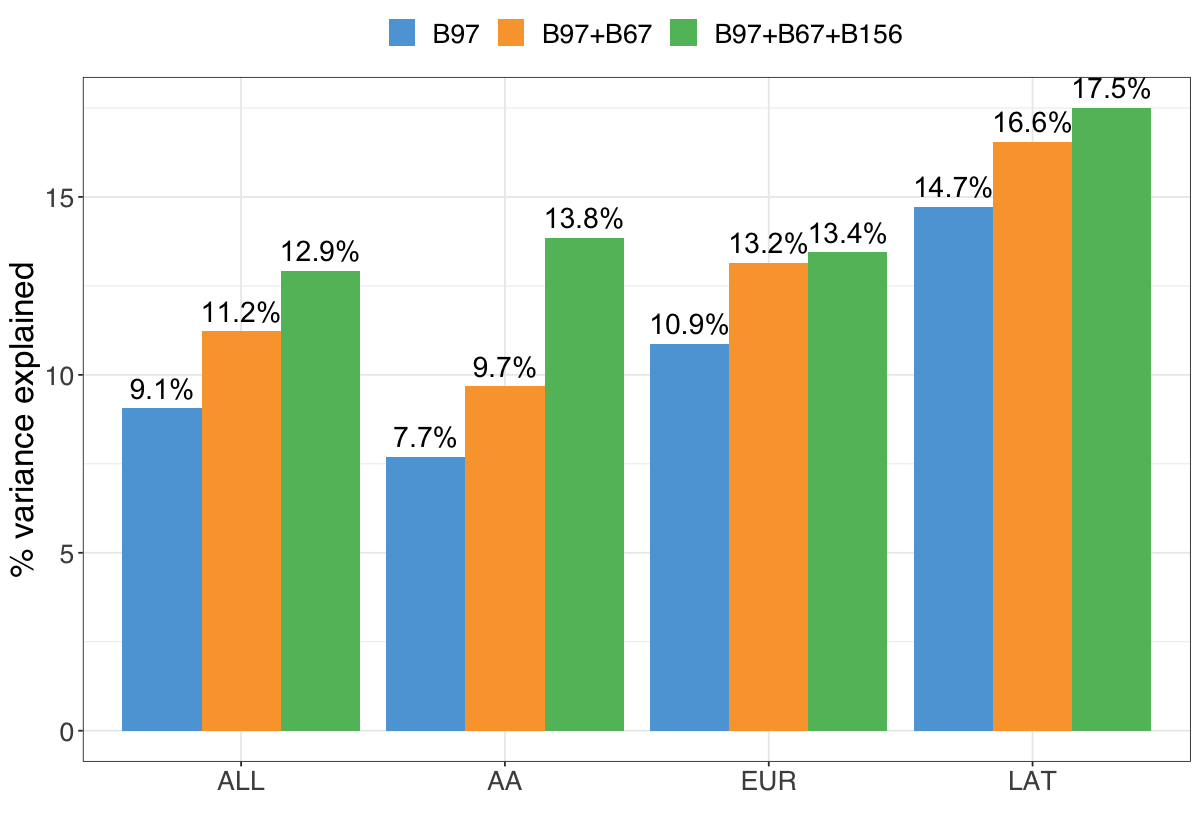

In [180]:
x <- read.table("../data/varExp.txt",h=T,stringsAsFactors = F)
x
df <- melt(x[1:3,],id="pos")
df$pos <- factor(df$pos, levels = c("97","67","156"))
df$variable <- factor(df$variable, levels = c("ALL","AA","EUR" ,"LAT"))
#haplo_colors <- c('#88BDE6','#FBB258','#90CD97','#F6AAC9') # light color theme
haplo_colors <- c('#5DA5DA','#FAA43A','#60BD68','#F17CB0')
p <- ggplot(data = df,aes(x=as.factor(variable),y=value*100,fill=pos)) +
       geom_bar(stat="identity",position=position_dodge()) + 
    geom_text(aes(label=paste(round(value,3)*100,"%",sep="")), vjust=-.5, color="black",
            position = position_dodge(0.9), size=6) +
  scale_fill_manual(values=haplo_colors,name ="",
                    labels=c("B97","B97+B67","B97+B67+B156"))

p + theme(legend.position="top") + ylab("% variance explained") + xlab("")

ggsave("../figs/Fig5e_haplotype_variance.pdf", height = 8, width = 10)
